# Import the libraries

In [2]:
import warnings
warnings.filterwarnings("ignore")

import seaborn as sb
import matplotlib.pyplot as plt

# Transform the text
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# Texts
from wordcloud import WordCloud

#Count common texts
from collections import Counter

from sklearn.preprocessing import LabelEncoder

#text to vetorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#train test split
from sklearn.model_selection import train_test_split

#models
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

#metics
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score

#voting classifier
from sklearn.ensemble import VotingClassifier

#for stacking
from sklearn.ensemble import StackingClassifier

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Read the data

In [4]:
df = pd.read_csv("spam.csv", encoding='latin1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


# Understanding the data

In [5]:
df.shape

(5572, 5)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


# Data Cleaning

In [7]:
df.drop(columns = ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace = True)

In [8]:
df.rename(columns = {'v1': 'target', 'v2': 'SMS'}, inplace = True)

In [9]:
le = LabelEncoder()
df['target'] = le.fit_transform(df['target'])

# Missing Values

In [10]:
df.isnull().sum()

target    0
SMS       0
dtype: int64

# Duplicate Values

In [11]:
df.duplicated().sum()

403

In [12]:
df = df.drop_duplicates(keep = 'first')

# Exploratory Data Analysis

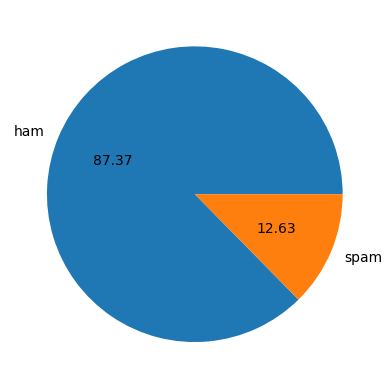

In [13]:
plt.pie(df['target'].value_counts(), labels = ['ham', 'spam'], autopct = '%0.2f')
plt.show()

Observation: Data is imbalanced

In [14]:
df['num_character'] = df['SMS'].apply(len)
df['num_words'] = df['SMS'].apply(lambda x: len(nltk.word_tokenize(x)))
df['num_setences'] = df['SMS'].apply(lambda x: len(nltk.sent_tokenize(x)))

In [15]:
df[['num_character', 'num_words', 'num_setences']].describe()

,num_character,num_words,num_setences
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.286129,1.961308
std,58.236293,13.226400,1.432583
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,219.000000,38.000000


In [16]:
# ham
df[df['target'] == 0][['num_character', 'num_words', 'num_setences']].describe()

,num_character,num_words,num_setences
count,4516.000000,4516.000000,4516.000000
mean,70.459256,16.957484,1.815545
std,56.358207,13.394052,1.364098
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,219.000000,38.000000


In [17]:
# spam
df[df['target'] == 1][['num_character', 'num_words', 'num_setences']].describe()

,num_character,num_words,num_setences
count,653.000000,653.000000,653.000000
mean,137.891271,27.474732,2.969372
std,30.137753,6.893007,1.488910
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,44.000000,9.000000


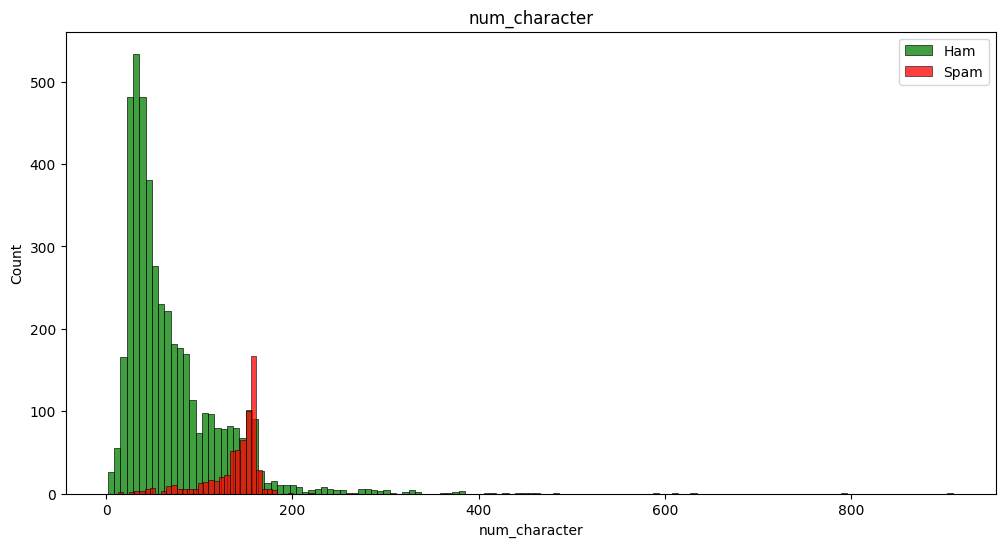

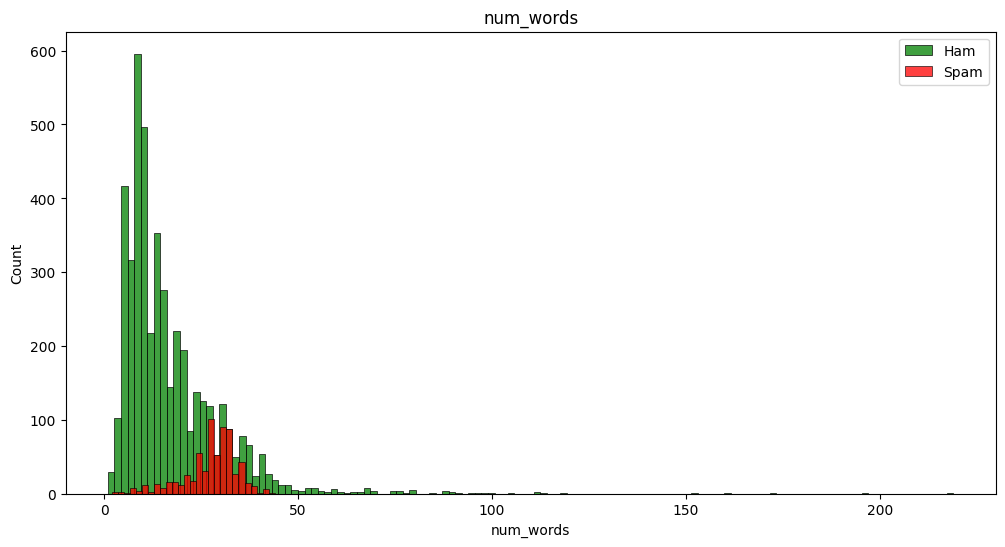

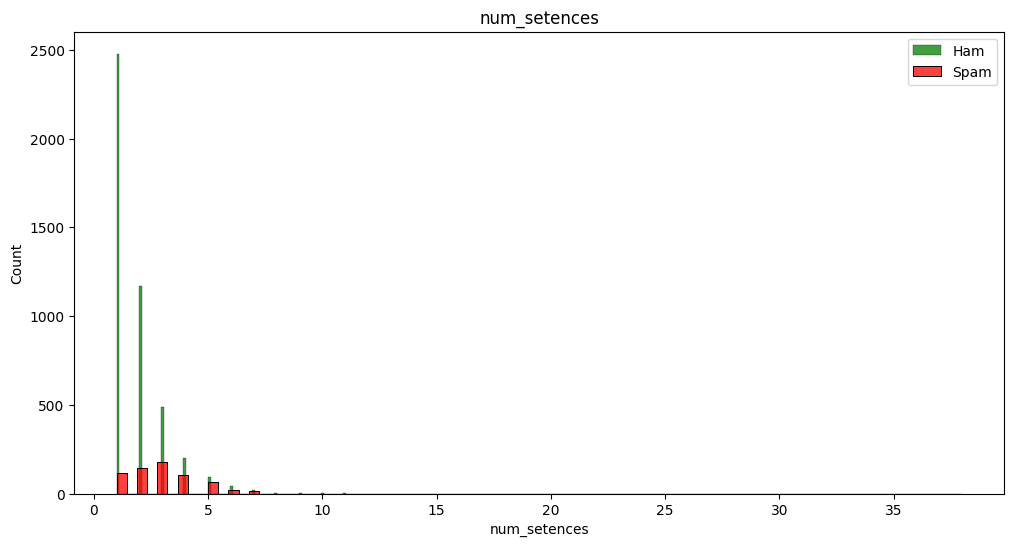

In [18]:
columns = ['num_character', 'num_words', 'num_setences']

for column in columns: 
    plt.figure(figsize = (12, 6))
    sb.histplot(df[df['target'] == 0][column], color = 'green')
    sb.histplot(df[df['target'] == 1][column], color = 'red')
    plt.legend({'Ham': 'Green', 'Spam': 'Red'})
    plt.title(column)
plt.show()

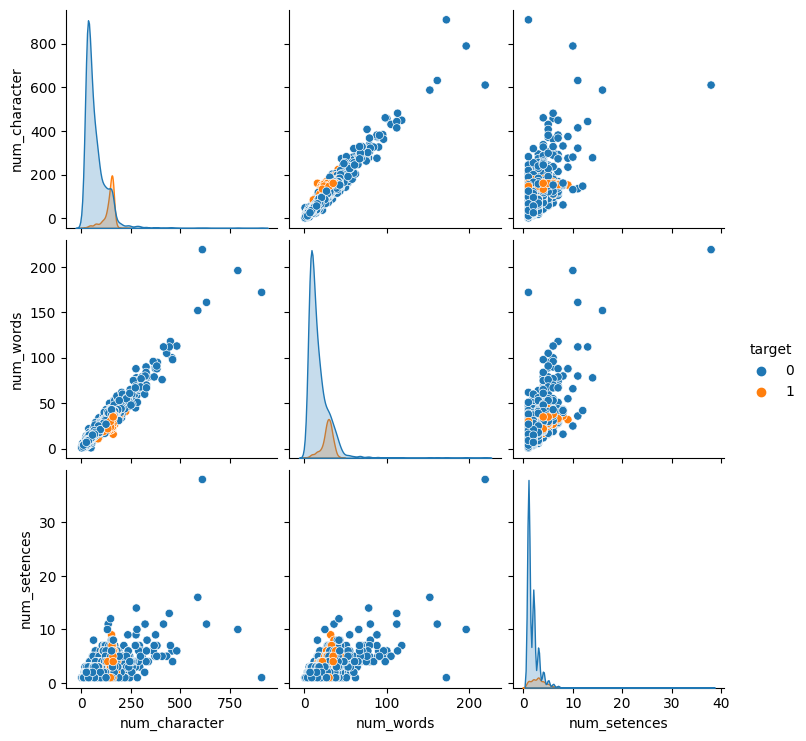

In [19]:
sb.pairplot(df, hue = 'target')

In [20]:
df.columns

Index(['target', 'SMS', 'num_character', 'num_words', 'num_setences'], dtype='object')

<Axes: >

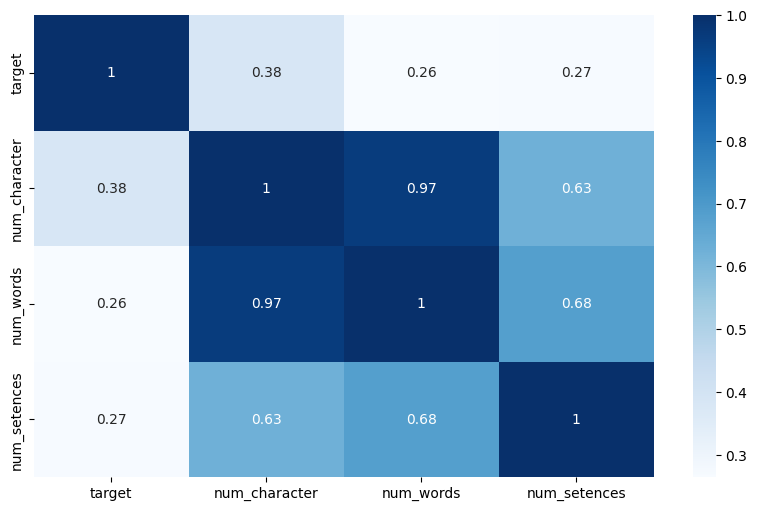

In [21]:
correlation = df[['target', 'num_character', 'num_words', 'num_setences']]

plt.figure(figsize = (10, 6))
sb.heatmap(correlation.corr(), annot = True, cmap = 'Blues')

# Data Preprocessing

In [22]:
def transform_SMS(text):
    
    # convert into lowercase
    text = text.lower()
    
    #Tokenization 
    text = nltk.word_tokenize(text)
    
    #Removing special characters
    list = []
    for i in text:
        if i.isalnum():
            list.append(i)
            
    #Removing stopwords and punctuation
    text = list[:]
    list.clear()
    
    for i in text:
        if i not in stopwords.words("english") and i not in string.punctuation:
            list.append(i)
    
    #Stemming
    text = list[:]
    list.clear()
    ps = PorterStemmer()
    
    for i in text:
        list.append(ps.stem(i))
            
    return " ".join(list)

In [23]:
df['transformed_text'] = df['SMS'].apply(transform_SMS)

# Ham and Spam Texts

In [24]:
wc = WordCloud(width = 500, height = 500, background_color = 'white', min_font_size = 10)

Text(0.5, 1.0, 'Spam words')

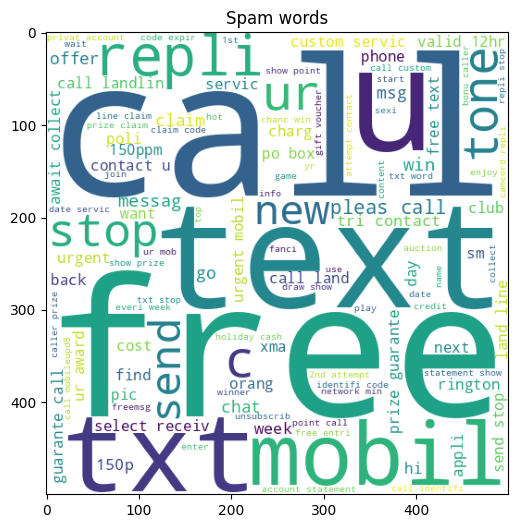

In [25]:
spam_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep = " "))
plt.figure(figsize = (15, 6))
plt.imshow(spam_wc)
plt.title("Spam words")

Text(0.5, 1.0, 'Ham words')

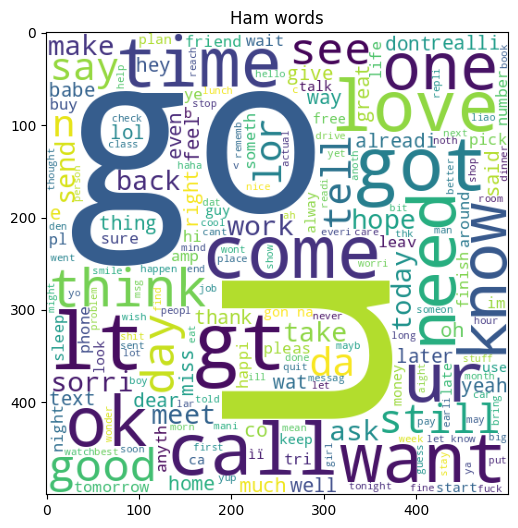

In [26]:
ham_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep = " "))
plt.figure(figsize = (15, 6))
plt.imshow(ham_wc)
plt.title("Ham words")

# Common Texts in Ham and Spam

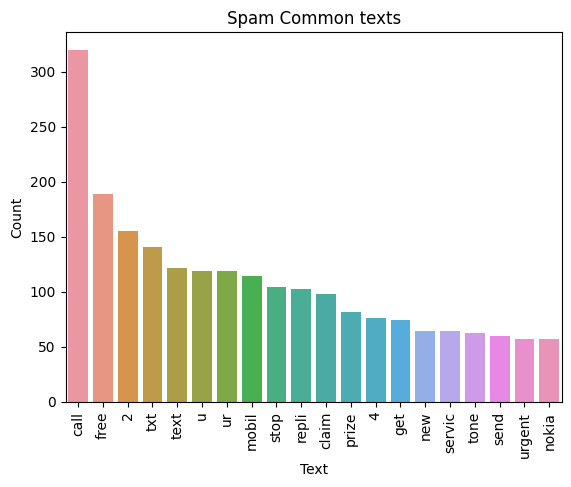

In [27]:
spam_corpus = []
for messages in df[df['target'] == 1]['transformed_text'].tolist():
    for word in messages.split():
        spam_corpus.append(word)
        
commom_spam_text = pd.DataFrame(Counter(spam_corpus).most_common(20))
sb.barplot(x = commom_spam_text[0], y = commom_spam_text[1], data = commom_spam_text)
plt.xlabel("Text")
plt.ylabel("Count")
plt.title("Spam Common texts")
plt.xticks(rotation = 90)
plt.show()

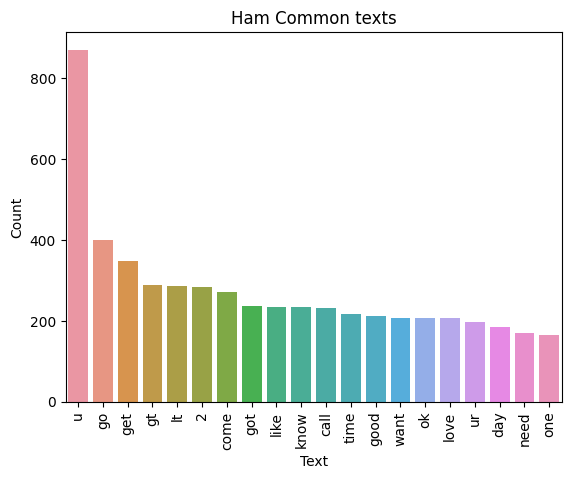

In [28]:
ham_corpus = []
for messages in df[df['target'] == 0]['transformed_text'].tolist():
    for word in messages.split():
        ham_corpus.append(word)
        
commom_ham_text = pd.DataFrame(Counter(ham_corpus).most_common(20))
sb.barplot(x = commom_ham_text[0], y = commom_ham_text[1], data = commom_spam_text)
plt.xlabel("Text")
plt.ylabel("Count")
plt.title("Ham Common texts")
plt.xticks(rotation = 90)
plt.show()

# Feature Selection

In [29]:
# tfidf = TfidfVectorizer()
tfidf_3000 = TfidfVectorizer(max_features= 3000)

X = tfidf_3000.fit_transform(df['transformed_text']).toarray()
y = df['target'].values

# Train text Split

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)

# Model Building

In [31]:
gaussian_nb = GaussianNB()
gaussian_nb.fit(X_train, y_train)
gaussian_nb_pred = gaussian_nb.predict(X_test)

print("Accuracy Score: ", accuracy_score(y_test, gaussian_nb_pred))
print("Confusion matrix: ", confusion_matrix(y_test, gaussian_nb_pred))
print("Precision Score: ", precision_score(y_test, gaussian_nb_pred))

Accuracy Score:  0.867504835589942
Confusion matrix:  [[785 111]
 [ 26 112]]
Precision Score:  0.5022421524663677


In [32]:
mutli_nb = MultinomialNB()
mutli_nb.fit(X_train, y_train)
mutli_nb_pred = mutli_nb.predict(X_test)

print("Accuracy Score: ", accuracy_score(y_test, mutli_nb_pred))
print("Confusion matrix: ", confusion_matrix(y_test, mutli_nb_pred))
print("Precision Score: ", precision_score(y_test, mutli_nb_pred))

Accuracy Score:  0.9729206963249516
Confusion matrix:  [[896   0]
 [ 28 110]]
Precision Score:  1.0


In [33]:
bernoulli_nb = BernoulliNB()
bernoulli_nb.fit(X_train, y_train)
bernoulli_nb_pred = bernoulli_nb.predict(X_test)

print("Accuracy Score: ", accuracy_score(y_test, bernoulli_nb_pred))
print("Confusion matrix: ", confusion_matrix(y_test, bernoulli_nb_pred))
print("Precision Score: ", precision_score(y_test, bernoulli_nb_pred))

Accuracy Score:  0.9816247582205029
Confusion matrix:  [[895   1]
 [ 18 120]]
Precision Score:  0.9917355371900827


In [34]:
svc = SVC(kernel = "sigmoid", gamma = 1.0)
knc = KNeighborsClassifier()
mutli_nb = MultinomialNB()
decision_tree = DecisionTreeClassifier(max_depth= 5)
logistic_regression = LogisticRegression(solver = 'liblinear', penalty = 'l1')
random_forest = RandomForestClassifier(n_estimators= 50, random_state= 2)
ada_boost = AdaBoostClassifier(n_estimators= 50, random_state= 2)
bagging_classifier = BaggingClassifier(n_estimators= 50, random_state= 2)
extra_trees = ExtraTreesClassifier(n_estimators= 50, random_state= 2)
gradient_boosting = GradientBoostingClassifier(n_estimators= 50, random_state= 2)
xgb_classifire = XGBClassifier(n_estimators= 50, random_state= 2)

In [35]:
clfs = {
    'SVC': svc,
    'KNC': knc,
    'MNB': mutli_nb,
    'DT': decision_tree,
    'LR': logistic_regression,
    'RF': random_forest,
    'ADABosst': ada_boost,
    'BaggingC': bagging_classifier,
    'ETC': extra_trees,
    'GBC': gradient_boosting,
    'xgb': xgb_classifire
}

def train_classifier(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    prediction = clf.predict(X_test)
    
    accuracy = accuracy_score(y_test, prediction)
    precision = precision_score(y_test, prediction)
    
    return accuracy, precision

In [36]:
accuracy_scores = []
precision_scores = []

for name, clf in clfs.items():
    accuracy, precision = train_classifier(clf, X_train, y_train, X_test, y_test)
    print("For ", name)
    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)

For  SVC
Accuracy:  0.9748549323017408
Precision:  0.9666666666666667
For  KNC
Accuracy:  0.9052224371373307
Precision:  1.0
For  MNB
Accuracy:  0.9729206963249516
Precision:  1.0
For  DT
Accuracy:  0.9352030947775629
Precision:  0.8585858585858586
For  LR
Accuracy:  0.9574468085106383
Precision:  0.9519230769230769
For  RF
Accuracy:  0.971953578336557
Precision:  0.9739130434782609
For  ADABosst
Accuracy:  0.9642166344294004
Precision:  0.9316239316239316
For  BaggingC
Accuracy:  0.9545454545454546
Precision:  0.8527131782945736
For  ETC
Accuracy:  0.9777562862669246
Precision:  0.9831932773109243
For  GBC
Accuracy:  0.9487427466150871
Precision:  0.9292929292929293
For  xgb
Accuracy:  0.9642166344294004
Precision:  0.9243697478991597


In [37]:
# without parameter tuning of TfIdf
scores_df = pd.DataFrame({'Algorithms': clfs.keys(), 'Accuracy': accuracy_scores,
                          'Precision': precision_scores}).sort_values('Precision', ascending= False)
scores_df

,Algorithms,Accuracy,Precision
1,KNC,0.905222,1.000000
2,MNB,0.972921,1.000000
8,ETC,0.977756,0.983193
5,RF,0.971954,0.973913
0,SVC,0.974855,0.966667
4,LR,0.957447,0.951923
6,ADABosst,0.964217,0.931624
9,GBC,0.948743,0.929293
10,xgb,0.964217,0.924370
3,DT,0.935203,0.858586


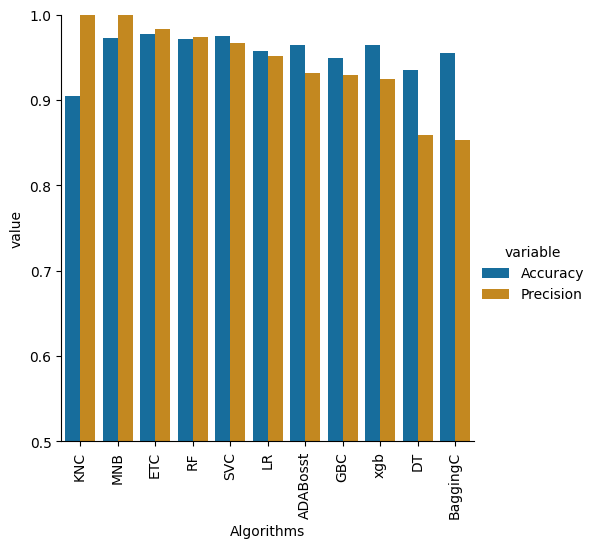

In [38]:
algos_accuracy = pd.melt(scores_df, id_vars = "Algorithms")
sb.catplot(x = 'Algorithms', y = 'value', hue = 'variable', data = algos_accuracy,
            kind = 'bar', height = 5, palette= 'colorblind')
plt.ylim(0.5, 1.0)
plt.xticks(rotation = 'vertical')
plt.show()

# Model Improvement

In [39]:
# changing max_features parameter of TfIdf
temp_df = pd.DataFrame({'Algorithms': clfs.keys(), 'Accuracy_max_df_3000': accuracy_scores,
                          'Precision_max_df_3000': precision_scores}).sort_values('Precision_max_df_3000', ascending= False)

In [40]:
scores_df.merge(temp_df, on = 'Algorithms')

,Algorithms,Accuracy,Precision,Accuracy_max_df_3000,Precision_max_df_3000
0,KNC,0.905222,1.000000,0.905222,1.000000
1,MNB,0.972921,1.000000,0.972921,1.000000
2,ETC,0.977756,0.983193,0.977756,0.983193
3,RF,0.971954,0.973913,0.971954,0.973913
4,SVC,0.974855,0.966667,0.974855,0.966667
5,LR,0.957447,0.951923,0.957447,0.951923
6,ADABosst,0.964217,0.931624,0.964217,0.931624
7,GBC,0.948743,0.929293,0.948743,0.929293
8,xgb,0.964217,0.924370,0.964217,0.924370
9,DT,0.935203,0.858586,0.935203,0.858586


# Voting Classifier on best performance classifier

In [41]:
svc = SVC(kernel = "sigmoid", gamma = 1.0, probability= True)
mutli_nb = MultinomialNB()
extra_trees = ExtraTreesClassifier(n_estimators= 50, random_state= 2)

voting = VotingClassifier(estimators= [('svc', svc), ('multi_nb', mutli_nb), ('et', extra_trees)], voting = 'soft')
voting.fit(X_train, y_train)

VotingClassifier(estimators=[('svc',
                              SVC(gamma=1.0, kernel='sigmoid',
                                  probability=True)),
                             ('multi_nb', MultinomialNB()),
                             ('et',
                              ExtraTreesClassifier(n_estimators=50,
                                                   random_state=2))],
                 voting='soft')

In [42]:
prediction = voting.predict(X_test)
print("Accuracy Score: ", accuracy_score(y_test, prediction))
print("Precision Score: ", precision_score(y_test, prediction))

Accuracy Score:  0.9796905222437138
Precision Score:  0.975609756097561


# Appling stacking

In [43]:
estimators= [('svc', svc), ('multi_nb', mutli_nb), ('et', extra_trees)]
final_estimator = RandomForestClassifier()
stacking_clf = StackingClassifier(estimators = estimators, final_estimator= final_estimator)
stacking_clf.fit(X_train, y_train)
prediction = stacking_clf.predict(X_test)
print("Accuracy Score: ", accuracy_score(y_test, prediction))
print("Precision Score: ", precision_score(y_test, prediction))

Accuracy Score:  0.9796905222437138
Precision Score:  0.9534883720930233


In [44]:
# Selecting Mutinomial Naive Bayes because it has hight precision
import pickle
pickle.dump(tfidf_3000, open('ventorizer.pkl', 'wb'))
pickle.dump(mutli_nb, open('model.pkl', 'wb'))